# EDA

In [1]:
# importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import skew
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
%matplotlib inline

data = pd.read_csv("housing.csv")

data.head(20)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,yes,2,no,furnished
5,10850000,7500,3,3,1,yes,no,yes,yes,2,yes,semi-furnished
6,10150000,8580,4,3,4,yes,no,no,yes,2,yes,semi-furnished
7,10150000,16200,5,3,2,yes,no,no,no,0,no,unfurnished
8,9870000,8100,4,1,2,yes,yes,yes,yes,2,yes,furnished
9,9800000,5750,3,2,4,yes,yes,no,yes,1,yes,unfurnished


In [2]:
from ydata_profiling import ProfileReport

# Generate a profile report
profile = ProfileReport(data, title="Pandas Profiling Report", explorative=True)

# Display the report
profile.to_notebook_iframe() 

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

 We want to predict houses prices , the price will be the target variable. There are numerical and categorical variable. The data does not have missing values.
area is highly overall correlated with price. This shows that area has a higher predictoy power compared to other variables

There are numerical, boolean and categorical variable. We want to use as much variable as possible to predict the houses price, this because more we have variable taken in account the more accurate the prediction will be

The histograms shows that the data are skewed to the right. This means the data is not normally distributed. There are potentials outliers, we will ingestigate these outliers to see if it they makes sense, in those cases we will keep them if not then, will drop them

variable bathrooms is highly imbalanced. These can create bias on the model. We will use log transformation to fix the imbalance

There are 82 outliers. The outliers pulls the mean towards them meaning the a very expensive house in a neigbourhood can make the average price of house look higher than what it is. We will drop the outliers

Bathroom is highly imbalanced we will remove that variable

Finding outliers using the Interquartile Range (IQR) method, which calculate a lower and upper bound using the quantiles, l
the data point which fall outside of those bounds are outliers

In [3]:
def detect_outliers_multi(data, columns):
    outliers = pd.DataFrame()
    
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        col_outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
        outliers = pd.concat([outliers, col_outliers])
    
    return outliers.drop_duplicates()

columns_to_check = ['price', 'area', 'bathrooms','bedrooms','stories', 'parking']
outliers = detect_outliers_multi(data, columns_to_check)

print("Outliers:")
print(outliers)

# To get the indices of the outliers:
outlier_indices = outliers.index.tolist()
print("\nOutlier indices:", outlier_indices)

outliers.count()

Outliers:
        price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0    13300000  7420         4          2        3      yes        no       no   
1    12250000  8960         4          4        4      yes        no       no   
2    12250000  9960         3          2        2      yes        no      yes   
3    12215000  7500         4          2        2      yes        no      yes   
4    11410000  7420         4          1        2      yes       yes      yes   
..        ...   ...       ...        ...      ...      ...       ...      ...   
304   4193000  8250         3          1        1      yes        no      yes   
323   4025000  5400         3          1        1      yes        no       no   
331   3920000  7260         3          2        1      yes       yes      yes   
401   3500000  9500         3          1        2      yes        no       no   
472   3010000  3630         4          1        2      yes        no       no   

    airconditioni

price               82
area                82
bedrooms            82
bathrooms           82
stories             82
mainroad            82
guestroom           82
basement            82
airconditioning     82
parking             82
prefarea            82
furnishingstatus    82
dtype: int64

array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'area'}>],
       [<Axes: title={'center': 'bedrooms'}>,
        <Axes: title={'center': 'bathrooms'}>],
       [<Axes: title={'center': 'stories'}>,
        <Axes: title={'center': 'parking'}>]], dtype=object)

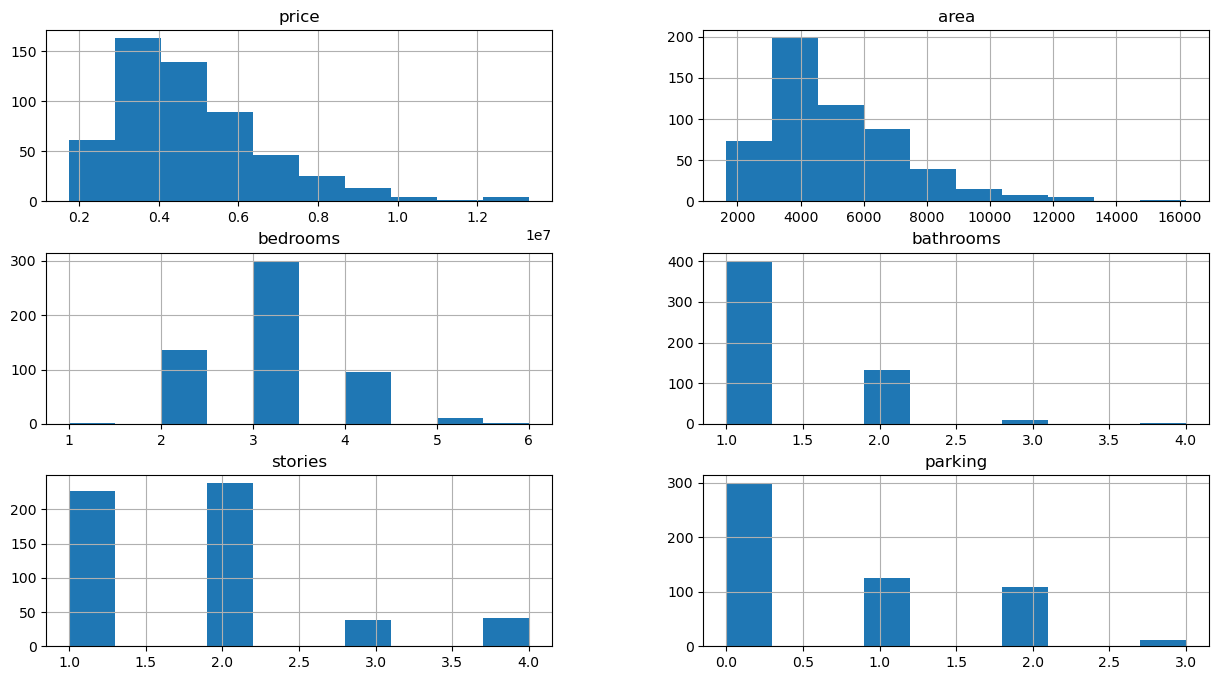

In [4]:
data.hist(figsize=(15,8))

In [5]:
# Select only numerical columns
numerical_columns = data.select_dtypes(include=['number'])

# Calculate and print skewness for each column
for column in numerical_columns.columns:
    skewness_value = skew(data[column])
    print(f'Skewness of {column}: {skewness_value:.2f}')

Skewness of price: 1.21
Skewness of area: 1.32
Skewness of bedrooms: 0.49
Skewness of bathrooms: 1.58
Skewness of stories: 1.08
Skewness of parking: 0.84


All the numerical variables have a positive skeweness , also known as right skewe. Since we are working with regressions models we want normally distributed data. In order fix the skeweness and makes these variables normally distributed. We will use a log transformation. We will assume normally distributed have a skeweness between -1 and 1 

Visually we can see all of the variables data are skewed to the right, the normal range for data skeweness is between -1 and 1 for a normal distribution. Since we are will be using a linear regression to predict the price, we need a normally distributed data. We will use the log method because it is widely used to positive skewed data which is the case here. We will use the log transformation to fix skeweness

# Feature Engineering

In [6]:
# Removing outliers

def remove_outliers_multi(data, columns):
    outliers = detect_outliers_multi(data, columns)
    return data.drop(outliers.index)

# Use the function
columns_to_check = ['price', 'area', 'bathrooms','bedrooms','stories', 'parking']
data_without_outliers = remove_outliers_multi(data, columns_to_check)

# Print the shape of the original and cleaned datasets
print("Original dataset shape:", data.shape)
print("Dataset without outliers shape:", data_without_outliers.shape)

# Calculate the number of rows removed
rows_removed = data.shape[0] - data_without_outliers.shape[0]
print(f"Number of outlier rows removed: {rows_removed}")

Original dataset shape: (545, 12)
Dataset without outliers shape: (463, 12)
Number of outlier rows removed: 82


In [7]:
# renaming dataframe

data = data_without_outliers

data

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,airconditioning,parking,prefarea,furnishingstatus
15,9100000,6000,4,1,2,yes,no,yes,no,2,no,semi-furnished
16,9100000,6600,4,2,2,yes,yes,yes,yes,1,yes,unfurnished
18,8890000,4600,3,2,2,yes,yes,no,yes,2,no,furnished
19,8855000,6420,3,2,2,yes,no,no,yes,1,yes,semi-furnished
20,8750000,4320,3,1,2,yes,no,yes,no,2,no,semi-furnished
...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,yes,no,yes,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,0,no,furnished


In [8]:
# Removing imbalanced variable

data = data.drop('bathrooms', axis = 1)

In [9]:
data

,price,area,bedrooms,stories,mainroad,guestroom,basement,airconditioning,parking,prefarea,furnishingstatus
15,9100000,6000,4,2,yes,no,yes,no,2,no,semi-furnished
16,9100000,6600,4,2,yes,yes,yes,yes,1,yes,unfurnished
18,8890000,4600,3,2,yes,yes,no,yes,2,no,furnished
19,8855000,6420,3,2,yes,no,no,yes,1,yes,semi-furnished
20,8750000,4320,3,2,yes,no,yes,no,2,no,semi-furnished
...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,yes,no,yes,no,2,no,unfurnished
541,1767150,2400,3,1,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,yes,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,no,no,no,no,0,no,furnished


In [10]:
# After removing the outliers the skweness is now fixed enough for normal distribution

In [11]:
# Select only numerical columns
numerical_columns = data.select_dtypes(include=['number'])

# Calculate and print skewness for each column
for column in numerical_columns.columns:
    skewness_value = skew(data[column])
    print(f'Skewness of {column}: {skewness_value:.2f}')
    

Skewness of price: 0.86
Skewness of area: 0.90
Skewness of bedrooms: 0.07
Skewness of stories: 0.51
Skewness of parking: 0.86


All the skeweness are now under or is 1 and more than -1. Now these are normally distributed

array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'area'}>],
       [<Axes: title={'center': 'bedrooms'}>,
        <Axes: title={'center': 'stories'}>],
       [<Axes: title={'center': 'parking'}>, <Axes: >]], dtype=object)

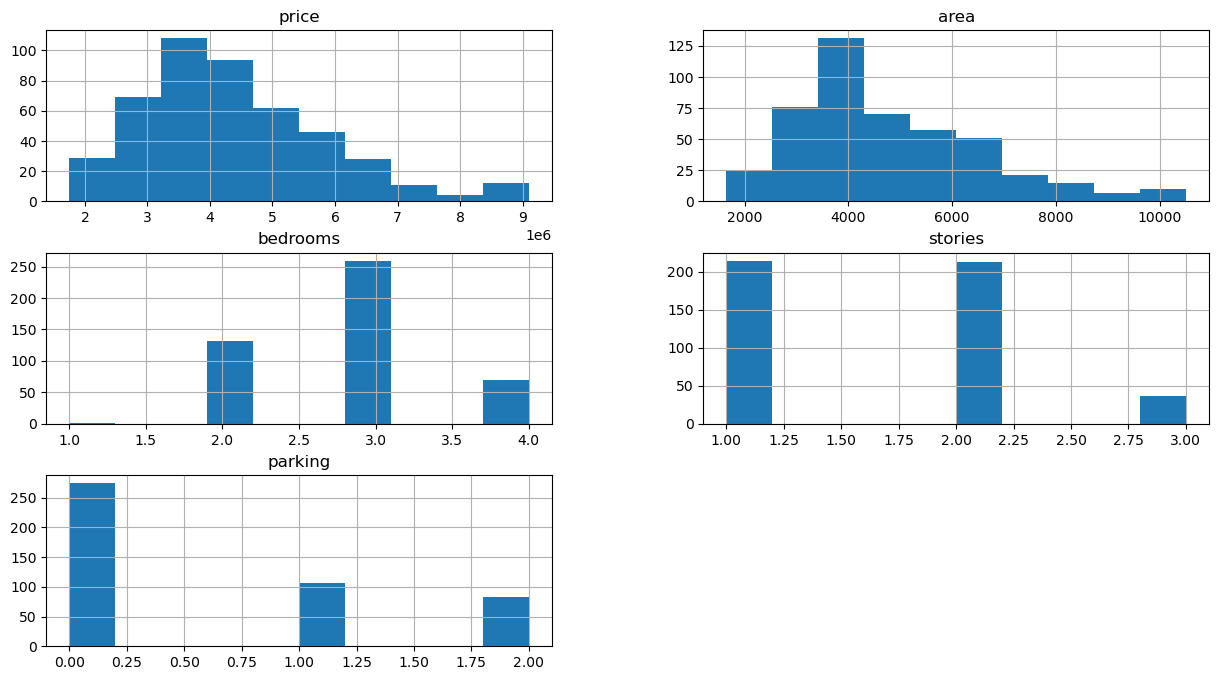

In [12]:
data.hist(figsize=(15,8))

In [13]:
from ydata_profiling import ProfileReport

# Generate a profile report
profile = ProfileReport(data, title="Pandas Profiling Report", explorative=True)

# Display the report
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

The data is now clean, we can now move to encoding the the categorical variables

## dealing with categorical varriables

What happens is that we want to use the categorical variables to predict the price, the machine does not understand the "yes", "no", 'semi-furnished', etc. So we have to turn these into something the machine can work with

furnishingstatus has no order we will use Onehot encoding which works well with variables with order
all the variables with yes and no  will be transformed using Binary encoder which works well with variables with non order and with two outcomes

In [14]:
data.head(5)

,price,area,bedrooms,stories,mainroad,guestroom,basement,airconditioning,parking,prefarea,furnishingstatus
15,9100000,6000,4,2,yes,no,yes,no,2,no,semi-furnished
16,9100000,6600,4,2,yes,yes,yes,yes,1,yes,unfurnished
18,8890000,4600,3,2,yes,yes,no,yes,2,no,furnished
19,8855000,6420,3,2,yes,no,no,yes,1,yes,semi-furnished
20,8750000,4320,3,2,yes,no,yes,no,2,no,semi-furnished


In [15]:
# One Hot encoding

data = pd.get_dummies(data, columns=['furnishingstatus'], dtype=int)


#Binary encoding

# Convert to lowercase and map
data['prefarea'] = data['prefarea'].str.lower().map({'yes': 1, 'no': 0}).astype(int)
data['basement'] = data['basement'].str.lower().map({'yes': 1, 'no': 0}).astype(int)
data['guestroom'] = data['guestroom'].str.lower().map({'yes': 1, 'no': 0}).astype(int)
data['airconditioning'] = data['airconditioning'].str.lower().map({'yes': 1, 'no': 0}).astype(int)
data['mainroad'] = data['mainroad'].str.lower().map({'yes': 1, 'no': 0}).astype(int)

In [16]:
data.head(10)

,price,area,bedrooms,stories,mainroad,guestroom,basement,airconditioning,parking,prefarea,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
15,9100000,6000,4,2,1,0,1,0,2,0,0,1,0
16,9100000,6600,4,2,1,1,1,1,1,1,0,0,1
18,8890000,4600,3,2,1,1,0,1,2,0,1,0,0
19,8855000,6420,3,2,1,0,0,1,1,1,0,1,0
20,8750000,4320,3,2,1,0,1,0,2,0,0,1,0
21,8680000,7155,3,1,1,1,1,1,2,0,0,0,1
22,8645000,8050,3,1,1,1,1,1,1,0,1,0,0
23,8645000,4560,3,2,1,1,1,1,1,0,1,0,0
24,8575000,8800,3,2,1,0,0,1,2,0,1,0,0
25,8540000,6540,4,2,1,1,1,1,2,1,1,0,0


Now the data is clean and encoded in the way the model can work with, we will now move forward to the model building stage

# Building first model

First we will separate the dataset into two dataframes. One has the depandant variables called X and the other has only the target variable called y. We will use a scaler function to scale the variables so that variables with big numbers like price and area do not overshadow the other variables
Then we will split both dataframes into a training and test sets. The training will be 80% of the the set and the test will be 20%. We do that so the model can train on 80% of the data and use the rest of the data to test the model. After that we will create a linear regression model then use the fit function to learn patterns from the data to make prediction on new data.
Also we will evaluate the model using r 2 score, mean square error and RMSE


In [17]:

# Define features (X) and target (y)
X = data.drop('price', axis=1)
y = data['price']

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler and scale the training and testing features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate the model
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Display the results
print("Training R² Score:", train_r2)
print("Test R² Score:", test_r2)
print("Training RMSE:", train_rmse)
print("Test RMSE:", test_rmse)


Training R² Score: 0.5462819506295312
Test R² Score: 0.6369967209764773
Training RMSE: 958040.2166840996
Test RMSE: 972164.5495235146


In [18]:
diff = train_r2-test_r2
print(diff)

diff_RMSE = train_rmse-test_rmse
print(diff_RMSE)

-0.09071477034694608
-14124.332839414943


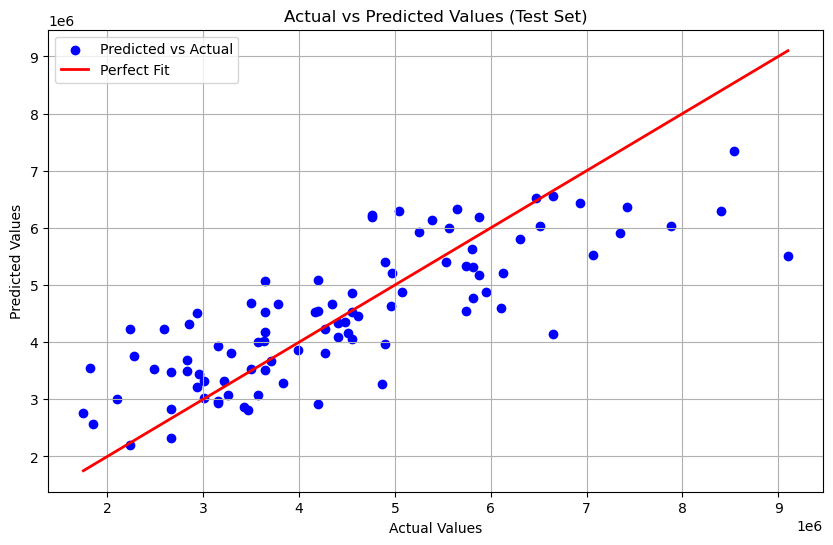

In [19]:

# Actual vs Predicted Plot for Test Data
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue', label="Predicted vs Actual")
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', lw=2, label="Perfect Fit")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Test Set)')
plt.legend()
plt.grid(True)
plt.show()



In [20]:
import numpy as np

# Assuming y is your target variable
mean = np.mean(y)
print(f"Mean of target variable: {mean}")
print(f"RMSE/Mean ratio: {test_rmse/mean:.2%}")

Mean of target variable: 4373745.140388769
RMSE/Mean ratio: 22.23%


## Observations


R² Score measures how well the model explains the variance in the target variable. This current model explains 55% of the variance in the training data and 64% on unseen data. This is very low. The perfect models R2 score are 100%. 
Also the difference bewteen the r 2 score on the training and test is very small 9%, this shows that the model is not overfitting which happens when the model comply too much to the training set but bad at capturing patterns in unseen data

The RMSE/Mean ratio of 22.23% suggests that, on average, the model's predictions deviate by about 22.23% from the mean target value

We will try random forest regression and hyperparameter tuning to see if there random forest forest is better and if the adjusting some hyperparameter of the algorythm can help improve the model

# Improving model and find the best model and hyperparameters

## building other models and hyperparameter tuning 

In [21]:
## Random forest

In [22]:
###### from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 

# Define features (X) and target (y)
X = data.drop('price', axis=1)
y = data['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler and scale the training and testing features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Random Forest model with the best parameters
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='auto',
    n_jobs=-1,
    random_state=42
)
# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Make predictions on the training and test sets
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Calculate performance metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)  # squared=False gives RMSE
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# Print the results
print(f"Training R² Score: {train_r2:.4f}")
print(f"Test R² Score: {test_r2:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")


C:\Users\HPEnvy\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Training R² Score: 0.9241
Test R² Score: 0.5838
Training RMSE: 391793.5670
Test RMSE: 1040941.5589


Observation

The difference the training and test R2 score is 0.58 which show that the model is overfitting, the model does poorly on unseen data

In [23]:
## Hyperparameter tuning

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation R² Score:", best_score)

# Fit the model with the best parameters on the full training set
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# Evaluate on the test set
y_test_pred = best_rf.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Test R² Score:", test_r2)
print("Test RMSE:", test_rmse)

Fitting 10 folds for each of 243 candidates, totalling 2430 fits
Best Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation R² Score: 0.4840646559195709
Test R² Score: 0.5718953894824597
Test RMSE: 1055746.034278243


Observation

Best Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}. These are the parameters if we want a better model with less overfitting as the R2 score difference between the training and test will be very low

## tuned model 

In [25]:
# Define features (X) and target (y)
X = data.drop('price', axis=1)
y = data['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler and scale the training and testing features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Random Forest model with the best parameters
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)
# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Make predictions on the training and test sets
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Calculate performance metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)  # squared=False gives RMSE
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# Print the results
print(f"Training R² Score: {train_r2:.4f}")
print(f"Test R² Score: {test_r2:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Training R² Score: 0.6559
Test R² Score: 0.5719
Training RMSE: 834310.9019
Test RMSE: 1055746.0343


Observation

Slight improvement on the overfitting

In [26]:
!pip install xgboost

In [27]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, train_test_split
import numpy as np

# Create and train model
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

# Cross validation scores
xgb_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='r2')
print(f"XGB CV R² Scores: {xgb_scores.mean():.4f} (+/- {xgb_scores.std() * 2:.4f})")

# Train-test split for detailed metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Initialize the scaler and scale the training and testing features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

xgb_model.fit(X_train, y_train)

# Get predictions
train_pred = xgb_model.predict(X_train)
test_pred = xgb_model.predict(X_test)

# Calculate metrics
train_r2 = xgb_model.score(X_train, y_train)
test_r2 = xgb_model.score(X_test, y_test)
train_rmse = np.sqrt(np.mean((y_train - train_pred) ** 2))
test_rmse = np.sqrt(np.mean((y_test - test_pred) ** 2))

print(f"\nTraining R² Score: {train_r2:.4f}")
print(f"Test R² Score: {test_r2:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# Get feature importance
importance = xgb_model.feature_importances_
importance_dict = dict(zip(X.columns, importance))
sorted_importance = dict(sorted(importance_dict.items(), key=lambda x: x[1], reverse=True))

XGB CV R² Scores: -13.7548 (+/- 14.6794)

Training R² Score: 0.8567
Test R² Score: 0.5874
Training RMSE: 538318.8293
Test RMSE: 1036407.6754


This still has a higher overfitting than than the linear regression model , the R2 score difference is 31%

In [28]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Initial model setup
xgb_model = XGBRegressor(random_state=42)

# Define the parameter grid
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 2, 3, 4, 5],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Randomized search with 5-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=500,  # Adjust this to explore more or fewer combinations
    scoring='r2',  # Use 'neg_root_mean_squared_error' for RMSE
    cv=10,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the randomized search
random_search.fit(X_train, y_train)

# Best parameters and performance
print("Best Parameters:", random_search.best_params_)
print("Best R² Score:", random_search.best_score_)

# Retrieve the best model
best_xgb_model = random_search.best_estimator_


Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.8}
Best R² Score: 0.49664889355231806


## Tuned Model

In [29]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, train_test_split
import numpy as np

# Create and train model
xgb_model = XGBRegressor(
    n_estimators=400,
    learning_rate=0.01,
    max_depth=3,
    gamma = 0.2,
    colsample_bytree = 0.8,
    subsample=1,
    min_child_weight=1,
    random_state=42
)

# Cross validation scores
xgb_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='r2')
print(f"XGB CV R² Scores: {xgb_scores.mean():.4f} (+/- {xgb_scores.std() * 2:.4f})")

# Train-test split for detailed metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Initialize the scaler and scale the training and testing features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

xgb_model.fit(X_train, y_train)

# Get predictions
train_pred = xgb_model.predict(X_train)
test_pred = xgb_model.predict(X_test)

# Calculate metrics
train_r2 = xgb_model.score(X_train, y_train)
test_r2 = xgb_model.score(X_test, y_test)
train_rmse = np.sqrt(np.mean((y_train - train_pred) ** 2))
test_rmse = np.sqrt(np.mean((y_test - test_pred) ** 2))

print(f"\nTraining R² Score: {train_r2:.4f}")
print(f"Test R² Score: {test_r2:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# Get feature importance
importance = xgb_model.feature_importances_
importance_dict = dict(zip(X.columns, importance))
sorted_importance = dict(sorted(importance_dict.items(), key=lambda x: x[1], reverse=True))

XGB CV R² Scores: -11.2836 (+/- 11.0786)

Training R² Score: 0.6804
Test R² Score: 0.5871
Training RMSE: 804122.9680
Test RMSE: 1036834.3480


# Trying linear regression model with only the top 3 predictors 

In [30]:
selected_columns = ['area', 'stories','airconditioning', 'price']
data = data[selected_columns]
data

,area,stories,airconditioning,price
15,6000,2,0,9100000
16,6600,2,1,9100000
18,4600,2,1,8890000
19,6420,2,1,8855000
20,4320,2,0,8750000
...,...,...,...,...
540,3000,1,0,1820000
541,2400,1,0,1767150
542,3620,1,0,1750000
543,2910,1,0,1750000


In [31]:

# Define features (X) and target (y)
X1 = data[['area', 'stories', 'airconditioning']]
y1 = data['price']

# Now you can proceed with your code, such as splitting the dataset or model training.

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Initialize the scaler and scale the training and testing features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate the model
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Display the results
print("Training R² Score:", train_r2)
print("Test R² Score:", test_r2)
print("Training RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Training R² Score: 0.38349616712907686
Test R² Score: 0.4674159773008254
Training RMSE: 1116756.7924470403
Test RMSE: 1177547.8749712913


Observation

By reducing the numbers indepandant feature the R2 score did not improve the RMSE did not improve either

In [32]:
## Polynomial Regression

In [33]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Define features (X) and target (y)
X = data.drop('price', axis=1)
y = data['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler and scale the training and testing features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply polynomial transformation
degree = 2  # You can adjust this degree
poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# Train the polynomial regression model
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Predict and evaluate
y_train_pred = model.predict(X_train_poly)
y_test_pred = model.predict(X_test_poly)

# Calculate performance metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Print performance metrics
print("Training R² Score:", train_r2)
print("Test R² Score:", test_r2)
print("Training RMSE:", train_rmse)
print("Test RMSE:", test_rmse)


Training R² Score: 0.40288614393657296
Test R² Score: 0.4818815634178293
Training RMSE: 1099054.6466281854
Test RMSE: 1161446.018183766


This shows less overfitting but a low R2 score compared to the linear regression

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 463 entries, 15 to 544
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   area             463 non-null    int64
 1   stories          463 non-null    int64
 2   airconditioning  463 non-null    int32
 3   price            463 non-null    int64
dtypes: int32(1), int64(3)
memory usage: 32.4 KB


Conclusion

We have tried a few models on this dataset, multiple linear regression, random forest regression, hyperarameter tuning,  XGBRegressorion, all the models have a close RMSE but the one with less overviffing , that'll be our final model, this is the linear regression model

# Final model

In [2]:
# Removing imbalanced variable

data = data.drop('bathrooms', axis = 1)

# Removing outliers
def detect_outliers_multi(data, columns):
    outliers = pd.DataFrame()
    
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        col_outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
        outliers = pd.concat([outliers, col_outliers])
    
    return outliers.drop_duplicates()

columns_to_check = ['price', 'area','bedrooms','stories', 'parking']
outliers = detect_outliers_multi(data, columns_to_check)

print("Outliers:")
print(outliers)

# To get the indices of the outliers:
outlier_indices = outliers.index.tolist()
print("\nOutlier indices:", outlier_indices)

outliers.count()
def remove_outliers_multi(data, columns):
    outliers = detect_outliers_multi(data, columns)
    return data.drop(outliers.index)

# Use the function
columns_to_check = ['price', 'area','bedrooms','stories', 'parking']
data_without_outliers = remove_outliers_multi(data, columns_to_check)

# Print the shape of the original and cleaned datasets
print("Original dataset shape:", data.shape)
print("Dataset without outliers shape:", data_without_outliers.shape)


# Calculate the number of rows removed
rows_removed = data.shape[0] - data_without_outliers.shape[0]
print(f"Number of outlier rows removed: {rows_removed}")

# rename dataframe

data = data_without_outliers


# One Hot encoding

data = pd.get_dummies(data, columns=['furnishingstatus'], dtype=int)

#Binary encoding

# Convert to lowercase and map
data['prefarea'] = data['prefarea'].str.lower().map({'yes': 1, 'no': 0}).astype(int)
data['basement'] = data['basement'].str.lower().map({'yes': 1, 'no': 0}).astype(int)
data['guestroom'] = data['guestroom'].str.lower().map({'yes': 1, 'no': 0}).astype(int)
data['airconditioning'] = data['airconditioning'].str.lower().map({'yes': 1, 'no': 0}).astype(int)
data['mainroad'] = data['mainroad'].str.lower().map({'yes': 1, 'no': 0}).astype(int)

# Define features (X) and target (y)
X = data.drop('price', axis=1)
y = data['price']

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler and scale the training and testing features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate the model
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Display the results
print("Training R² Score:", train_r2)
print("Test R² Score:", test_r2)
print("Training RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Outliers:
        price  area  bedrooms  stories mainroad guestroom basement  \
0    13300000  7420         4        3      yes        no       no   
1    12250000  8960         4        4      yes        no       no   
2    12250000  9960         3        2      yes        no      yes   
3    12215000  7500         4        2      yes        no      yes   
4    11410000  7420         4        2      yes       yes      yes   
..        ...   ...       ...      ...      ...       ...      ...   
304   4193000  8250         3        1      yes        no      yes   
323   4025000  5400         3        1      yes        no       no   
331   3920000  7260         3        1      yes       yes      yes   
401   3500000  9500         3        2      yes        no       no   
472   3010000  3630         4        2      yes        no       no   

    airconditioning  parking prefarea furnishingstatus  
0               yes        2      yes        furnished  
1               yes        3       

In [ ]:
# Actual vs Predicted Plot for Test Data
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue', label="Predicted vs Actual")
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', lw=2, label="Perfect Fit")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Test Set)')
plt.legend()
plt.grid(True)
plt.show()

# Conclusion
The graph shows how the models (red line) fits the data. in our final model the model fits the data quiete well

Our final model explains 64.43% of the variation in the training set and explains 64.12% of the test set, the difference is very small meaning the model is not overfitting and is good as good at training as at unseen data, unseen is data house prices we will want to know
The RMSE/Mean ratio are respectively 1.37% and 1.72% for the training and test. This model error is 1.37% of the actual price during training and 1.72% of the actual house price on unseen data .This is very low error thus good.

The perfect R2 score is 1 and we have 0.64 for our model, this means there are other factors that predict houses prices not captured in this dataset like, location, is the house in NYC? is the house from a celebrity? These are just my personal speculations, if we have all these factors then we will be able to create a perfect model for predicting house prices

In [ ]:
# Get feature names, coefficients and intercept
feature_names = X.columns.tolist()
coefficients = model.coef_
intercept = model.intercept_

# Create a DataFrame to show coefficients nicely
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort by absolute value of coefficient to see most important features
coef_df['Abs_Coefficient'] = abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

print("Multiple Linear Regression Results:")
print("\nIntercept:", round(intercept, 4))
print("\nCoefficients:")
for index, row in coef_df.iterrows():
    print(f"{row['Feature']}: {row['Coefficient']:.4f}")

# Print equation
print("\nRegression Equation:")
equation = f"y = {intercept:.4f}"
for index, row in coef_df.iterrows():
    if row['Coefficient'] >= 0:
        equation += f" + {row['Coefficient']:.4f}*{row['Feature']}"
    else:
        equation += f" - {abs(row['Coefficient']):.4f}*{row['Feature']}"
print(equation)

# Model evaluation metrics
y_pred = model.predict(X_test)
print("\nModel Performance:")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

In [ ]:
# Calculate RMSE on log-transformed scale
train_rmse_log = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse_log = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Convert RMSE back to original scale
train_rmse_original = np.exp(train_rmse_log)
test_rmse_original = np.exp(test_rmse_log)

print("RMSE on Log-transformed Scale:")
print(f"Training RMSE (log scale): {train_rmse_log:.4f}")
print(f"Test RMSE (log scale): {test_rmse_log:.4f}")

print("\nRMSE on Original Scale:")
print(f"Training RMSE (original scale): {train_rmse_original:.4f}")
print(f"Test RMSE (original scale): {test_rmse_original:.4f}")

# Calculate percentage error
train_percentage_error = (train_rmse_original / np.exp(y_train.mean())) * 100
test_percentage_error = (test_rmse_original / np.exp(y_test.mean())) * 100

print("\nPercentage Error:")
print(f"Training Error: {train_percentage_error:.2f}%")
print(f"Test Error: {test_percentage_error:.2f}%")

# Calculate mean house prices for reference
mean_price_train = np.exp(y_train.mean())
mean_price_test = np.exp(y_test.mean())

print("\nMean House Prices:")
print(f"Training Set Mean Price: {mean_price_train:.2f}")
print(f"Test Set Mean Price: {mean_price_test:.2f}")

# Creating a dash where using can add indepaendant variables information and get a predicted price

In [5]:
from dash import Dash, html, dcc, callback, Output, Input, State
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from joblib import load, dump

# Initialize the Dash app
app = Dash(__name__)

# Load the model and scaler
model = load('house_price_model.joblib')
scaler = load('scaler.joblib')

# App layout
app.layout = html.Div([
    html.H1("House Price Predictor", 
            style={'textAlign': 'center', 'color': 'navy', 'marginBottom': '30px'}),
    
    # Input Form
    html.Div([
        # Area Input
        html.Div([
            html.Label("Area (sqft)", style={'fontSize': '18px', 'color': 'navy'}),
            dcc.Input(
                id='area',
                type='number',
                placeholder='Enter area...',
                style={'width': '200px', 'height': '30px', 'marginBottom': '20px'}
            ),
        ]),
        
        # Bedrooms Input
        html.Div([
            html.Label("Bedrooms", style={'fontSize': '18px', 'color': 'navy'}),
            dcc.Input(
                id='bedrooms',
                type='number',
                placeholder='Number of bedrooms...',
                style={'width': '200px', 'height': '30px', 'marginBottom': '20px'}
            ),
        ]),
        
        # Stories Input
        html.Div([
            html.Label("Stories", style={'fontSize': '18px', 'color': 'navy'}),
            dcc.Input(
                id='stories',
                type='number',
                placeholder='Number of stories...',
                style={'width': '200px', 'height': '30px', 'marginBottom': '20px'}
            ),
        ]),
        
        # Parking Input
        html.Div([
            html.Label("Parking", style={'fontSize': '18px', 'color': 'navy'}),
            dcc.Input(
                id='parking',
                type='number',
                placeholder='Number of parking spaces...',
                style={'width': '200px', 'height': '30px', 'marginBottom': '20px'}
            ),
        ]),
        
        # Binary Features
        html.Div([
            html.Label("Main Road Access?", style={'fontSize': '16px'}),
            dcc.RadioItems(
                id='mainroad',
                options=[{'label': 'Yes', 'value': 1}, {'label': 'No', 'value': 0}],
                value=1,
                inline=True,
                style={'marginBottom': '10px'}
            ),
        ]),
        
        html.Div([
            html.Label("Guest Room?", style={'fontSize': '16px'}),
            dcc.RadioItems(
                id='guestroom',
                options=[{'label': 'Yes', 'value': 1}, {'label': 'No', 'value': 0}],
                value=0,
                inline=True,
                style={'marginBottom': '10px'}
            ),
        ]),
        
        html.Div([
            html.Label("Basement?", style={'fontSize': '16px'}),
            dcc.RadioItems(
                id='basement',
                options=[{'label': 'Yes', 'value': 1}, {'label': 'No', 'value': 0}],
                value=0,
                inline=True,
                style={'marginBottom': '10px'}
            ),
        ]),
        
        html.Div([
            html.Label("Air Conditioning?", style={'fontSize': '16px'}),
            dcc.RadioItems(
                id='airconditioning',
                options=[{'label': 'Yes', 'value': 1}, {'label': 'No', 'value': 0}],
                value=1,
                inline=True,
                style={'marginBottom': '10px'}
            ),
        ]),
        
        html.Div([
            html.Label("Preferred Area?", style={'fontSize': '16px'}),
            dcc.RadioItems(
                id='prefarea',
                options=[{'label': 'Yes', 'value': 1}, {'label': 'No', 'value': 0}],
                value=1,
                inline=True,
                style={'marginBottom': '10px'}
            ),
        ]),
        
        html.Div([
            html.Label("Furnishing Status", style={'fontSize': '16px'}),
            dcc.Dropdown(
                id='furnishingstatus',
                options=[
                    {'label': 'Furnished', 'value': 2},
                    {'label': 'Semi-Furnished', 'value': 1},
                    {'label': 'Unfurnished', 'value': 0}
                ],
                value=2,
                style={'width': '200px', 'marginBottom': '20px'}
            ),
        ]),
        
        # Predict Button
        html.Button('Predict Price', 
                   id='predict-button', 
                   n_clicks=0,
                   style={
                       'fontSize': '18px',
                       'backgroundColor': 'navy',
                       'color': 'white',
                       'padding': '10px 20px',
                       'marginTop': '20px',
                       'border': 'none',
                       'borderRadius': '5px',
                       'cursor': 'pointer'
                   }),
        
        # Output
        html.Div([
            html.H3("Results:", 
                   style={'textAlign': 'center', 'color': 'navy', 'marginTop': '20px'}),
            html.Div(id='prediction-output', 
                    style={'textAlign': 'center', 'marginTop': '10px'})
        ]),
        
        # Transformation Details
        html.Div(id='debug-output', 
                style={'marginTop': '20px', 'fontSize': '14px', 'color': 'gray'})
        
    ], style={
        'display': 'flex',
        'flexDirection': 'column',
        'alignItems': 'center',
        'padding': '20px',
        'backgroundColor': '#f8f9fa',
        'borderRadius': '10px',
        'boxShadow': '0 4px 8px rgba(0,0,0,0.1)',
        'maxWidth': '800px',
        'margin': 'auto'
    })
])

@app.callback(
    [Output('prediction-output', 'children'),
     Output('debug-output', 'children')],
    Input('predict-button', 'n_clicks'),
    [State('area', 'value'),
     State('bedrooms', 'value'),
     State('stories', 'value'),
     State('parking', 'value'),
     State('mainroad', 'value'),
     State('guestroom', 'value'),
     State('basement', 'value'),
     State('airconditioning', 'value'),
     State('prefarea', 'value'),
     State('furnishingstatus', 'value')]
)
def predict_price(n_clicks, area, bedrooms, stories, parking, mainroad, 
                 guestroom, basement, airconditioning, prefarea, furnishingstatus):
    if n_clicks > 0 and all(v is not None for v in [area, bedrooms, stories, parking]):
        try:
            # 1. Original Values
            original_input = pd.DataFrame({
                'area': [area],
                'bedrooms': [bedrooms],
                'stories': [stories],
                'mainroad': [mainroad],
                'guestroom': [guestroom],
                'basement': [basement],
                'airconditioning': [airconditioning],
                'parking': [parking],
                'prefarea': [prefarea],
                'furnishingstatus': [furnishingstatus]
            })
            
            # 2. Log Transform
            log_input = original_input.copy()
            log_input['area'] = np.log(original_input['area'])
            log_input['stories'] = np.log(original_input['stories'])
            
            # 3. Scale Features
            scaled_input = scaler.transform(log_input)
            scaled_df = pd.DataFrame(scaled_input, columns=log_input.columns)
            
            # 4. Make Prediction
            log_price = model.predict(scaled_input)[0]
            final_price = np.exp(log_price)
            price_usd = final_price / 1
            
            # 5. Reverse Transformations
            reversed_area = np.exp(log_input['area'].values[0])
            reversed_stories = np.exp(log_input['stories'].values[0])
            
            # Prepare detailed output
            prediction_output = html.Div([
                # Original Values Section
                html.Div([
                    html.H4("Original Input Values", style={'color': 'navy'}),
                    html.P(f"Area: {area:,.0f} sq ft"),
                    html.P(f"Bedrooms: {bedrooms}"),
                    html.P(f"Stories: {stories}"),
                    html.P(f"Parking: {parking}"),
                    html.P(f"Main Road: {'Yes' if mainroad == 1 else 'No'}"),
                    html.P(f"Guest Room: {'Yes' if guestroom == 1 else 'No'}"),
                    html.P(f"Basement: {'Yes' if basement == 1 else 'No'}"),
                    html.P(f"Air Conditioning: {'Yes' if airconditioning == 1 else 'No'}"),
                    html.P(f"Preferred Area: {'Yes' if prefarea == 1 else 'No'}"),
                    html.P(f"Furnishing Status: {['Unfurnished', 'Semi-Furnished', 'Furnished'][furnishingstatus]}")
                ], style={'backgroundColor': '#e9ecef', 'padding': '15px', 'borderRadius': '5px', 'marginBottom': '15px'}),
                
                # Log Transformed Values
                html.Div([
                    html.H4("Log Transformed Values", style={'color': 'navy'}),
                    html.P(f"Log Area: {log_input['area'].values[0]:.4f}"),
                    html.P(f"Log Stories: {log_input['stories'].values[0]:.4f}")
                ], style={'backgroundColor': '#e9ecef', 'padding': '15px', 'borderRadius': '5px', 'marginBottom': '15px'}),
                
                # Scaled Values
                html.Div([
                    html.H4("Scaled Values", style={'color': 'navy'}),
                    *[html.P(f"{col}: {scaled_df[col].values[0]:.4f}") 
                      for col in scaled_df.columns]
                ], style={'backgroundColor': '#e9ecef', 'padding': '15px', 'borderRadius': '5px', 'marginBottom': '15px'}),
                
                # Predictions
                html.Div([
                    html.H4("Predictions", style={'color': 'navy'}),
                    html.P(f"Log Price: {log_price:.4f}"),
                    html.P(f"Final Price (USD): ${price_usd:,.2f}", style={'color': 'green', 'fontSize': '20px', 'fontWeight': 'bold'})
                ], style={'backgroundColor': '#e9ecef', 'padding': '15px', 'borderRadius': '5px'})
            ])
            
            # Debug output showing transformations
            debug_output = html.Div([
                html.H4("Transformation Process:", style={'color': 'navy'}),
                html.P(f"Area: {area:,.0f} → {log_input['area'].values[0]:.4f} → {scaled_df['area'].values[0]:.4f} → {reversed_area:,.0f}"),
                html.P(f"Stories: {stories} → {log_input['stories'].values[0]:.4f} → {scaled_df['stories'].values[0]:.4f} → {reversed_stories:.1f}"),
                html.P(f"Price: {log_price:.4f} → ₹{final_price:,.2f} → ${price_usd:,.2f}")
            ])
            
            return prediction_output, debug_output
            
        except Exception as e:
            return f"Error in prediction: {str(e)}", "Error occurred during calculation"
    
    return "Please fill all required fields", ""

if __name__ == '__main__':
    app.run_server(debug=True)


In [4]:
# -*- coding: utf-8 -*-
"""
@author: Alvaro Fuentes
Chapter 9. Hands-On Predictive Analytics with Python
Building a basic interactive app
"""
## imports
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
import pandas as pd
import os

app = dash.Dash(__name__, serve_locally=False)


app.css.append_css({
    'external_url': 'https://codepen.io/chriddyp/pen/bWLwgP.css'
})

numerical_features = ['price', 'area','bedrooms','stories', 'parking']
options_dropdown = [{'label':x.upper(), 'value':x} for x in numerical_features]

dd_x_var = dcc.Dropdown(
        id='x-var',
        options = options_dropdown,
        value = 'area'
        )

div_x_var =  html.Div(
        children=[html.H4('Variable for x axis: '), dd_x_var],
        className="six columns"
        )
        

dd_y_var = dcc.Dropdown(
        id='y-var',
        options = options_dropdown,
        value = 'price'
        ) 

div_y_var =  html.Div(
        children=[html.H4('Variable for y axis: '), dd_y_var],
        className="six columns"
        )

app.layout = html.Div(children=[
        html.H1('Adding interactive controls'),
        html.H2('Interactive scatter plot example'),
        html.Div(
                children=[div_x_var, div_y_var],
                className="row"
                ),  
        dcc.Graph(id='scatter')
        ])


@app.callback(
        Output(component_id='scatter', component_property='figure'),
        [Input(component_id='x-var', component_property='value'), Input(component_id='y-var', component_property='value')])
def scatter_plot(x_col, y_col):
    trace = go.Scatter(
            x = data[x_col],
            y = data[y_col],
            mode = 'markers'
            )
    
    layout = go.Layout(
            title = 'Scatter plot',
            xaxis = dict(title = x_col.upper()),
            yaxis = dict(title = y_col.upper())
            )
    
    output_plot = go.Figure(
            data = [trace],
            layout = layout
            )
    
    return output_plot
 
      
if __name__ == '__main__':
    app.run_server(debug=True)

C:\Users\HPEnvy\AppData\Local\Temp\ipykernel_3812\179812944.py:9: UserWarning:


The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

C:\Users\HPEnvy\AppData\Local\Temp\ipykernel_3812\179812944.py:10: UserWarning:


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`



This is not supported, switching to serve_locally=True


In [ ]:
!streamlit run app12.py